## Part 1: Basics of data processing

*by Morgane Desmau & Marco Alsina*

*Last update: January 2021*

The following notebook explains the following basic steps required to create a database in araucaria:

1. Read data into araucaria.
2. Perform aligment of spectra.
3. Merge spectra and calibrate reference channel.
4. Create a database with the original spectra.

### 1. Checking versions

It is always convenient to first check the version of `araucaria` and its dependencies, to verify that libraries are correctly loaded.

As seen in the output, this tutorial was developed with version 0.1.7c.
(your version could vary).

In [1]:
from araucaria.utils import get_version
print(get_version(dependencies=True))

Python version        : 3.8.3 (default, May 19 2020, 18:47:26) 
[GCC 7.3.0]
Numpy version         : 1.19.1
Scipy version         : 1.5.2
Lmfit version         : 1.0.1
Matplotlib version    : 3.3.1
Araucaria version     : 0.1.7c



### 2. Retrieving file names

The `testdata` module offers routines to retrieve filepaths from different beamlines that ship with `araucaria` for testing and example purposes.

In this case we will be reading and processing several scans of goethite (an iron oxyhydroxide), measured at at the Fe K-edge in the P65 beamline of DESY, Hamburg (data kindly provided by Morgane Desmau):

1. 20K_GOE_Fe_K_240.00000.xdi
2. 20K_GOE_Fe_K_240.00001.xdi
3. 20K_GOE_Fe_K_240.00002.xdi
4. 20K_GOE_Fe_K_240.00003.xdi
5. 20K_GOE_Fe_K_240.00004.xdi

In [2]:
# we first retrieve the proper filepaths to the files and store them in a list.
from pathlib import Path
from araucaria.testdata import get_testpath

fpaths = []
for i in range(0,5):
    path = get_testpath('20K_GOE_Fe_K_240.0000%i.xdi' % i)
    fpaths.append(path)

# checking that all filepaths are Path classes
all([isinstance(p, Path) for p in fpaths])

True

### 3. Reading, aligning and merging scans

Now that we have the paths to the files we can read them with the `read_p65` function:

- For convenience we will read both the transmission and reference channels of each scan file.
- Data will be stored together in a `Collection`.
- We will use a single scan (arbitrarily selected) for alignment of the remaining scans.
- After alignment, scans will be merged and a report printed.

In [3]:
from araucaria import Collection
from araucaria.io import read_p65
from araucaria.xas import align, merge

# container of data groups
collection = Collection()

# reading a single scan
ref = read_p65(fpaths[0], scan='mu', ref=True)
collection.add_group(ref)

# reading remaining scans and aligning them
for fpath in fpaths[1:]:
    group = read_p65(fpath, scan='mu', ref=True)
    align(group, ref, window=[-100,100])
    collection.add_group(group)

# merging scans
report, mgroup = merge(collection)
report.show()

id  filename                    mode  e_offset [eV]  e0 [eV]  
1   20K_GOE_Fe_K_240.00000.xdi  mu    0              7126.9   
2   20K_GOE_Fe_K_240.00001.xdi  mu    0.0225         7127.2   
3   20K_GOE_Fe_K_240.00002.xdi  mu    0.026688       7127     
4   20K_GOE_Fe_K_240.00003.xdi  mu    -0.000625      7126.9   
5   20K_GOE_Fe_K_240.00004.xdi  mu    0.0064375      7127.2   
--------------------------------------------------------------
    merge                       mu    0              7126.7   


### 4. Calibrating the merged scan

As seen in the report, the energy offsets after alignment are negligible, so we could have simply alignment before merging.

However, we need to verify that the energy of the merged reference channel corresponds to the absorption threshold at the Fe K-edge (7112 eV).

By default `merge()` reports the merge result on the primary channel (transmission in this case).
However, we can verify the energy of the merged reference channels by requesting it explicitily.

In [4]:
# merging only reference scans
report_ref, mgroup_ref = merge(collection, only_mu_ref=True)
report_ref.show()

id  filename                    mode    e_offset [eV]  e0 [eV]  
1   20K_GOE_Fe_K_240.00000.xdi  mu_ref  0              7111.5   
2   20K_GOE_Fe_K_240.00001.xdi  mu_ref  0.0225         7111.4   
3   20K_GOE_Fe_K_240.00002.xdi  mu_ref  0.026688       7111.3   
4   20K_GOE_Fe_K_240.00003.xdi  mu_ref  -0.000625      7111.2   
5   20K_GOE_Fe_K_240.00004.xdi  mu_ref  0.0064375      7111.2   
----------------------------------------------------------------
    merge                       mu_ref  0              7111.4   


In this case the merge report for the reference channel returns a value of 7111.4 eV, so lets go ahead and calibrate the merged scan.

After calibration we can verify final value of the absorption threshold with `find_e0`.

In [5]:
# calibrating and computing e0 for the merged reference scan.
from numpy import allclose
from araucaria.xas import calibrate, find_e0

e0       = 7112    # Fe K-edge
e_offset = calibrate(mgroup, e0, update=True)
e0_ref   = find_e0(mgroup, use_mu_ref=True)

# printing results
print('energy offset of merge: %1.3f eV' % e_offset)
print('e0 of merged reference: %1.1f eV' % e0_ref)
allclose(e0, e0_ref)

energy offset of merge: 0.595 eV
e0 of merged reference: 7112.0 eV


True

### 5. Plotting merge results

One merge is complete, we can pass the merged group and the original collection to `plot_merge` to visualize the results.

`plot_merge` allows a dictionary to set the parameters for the XAFS figures (`fig_pars`) as well as a dictionary to set general figure paramemeters (`fig_kws`). You can check the documentation for further details.

`plot_merge` even allows dictionaries to set the normalization and background removal procedures, but please note that these parameters are for visualization purposes only, and have no effect on the merge itself.

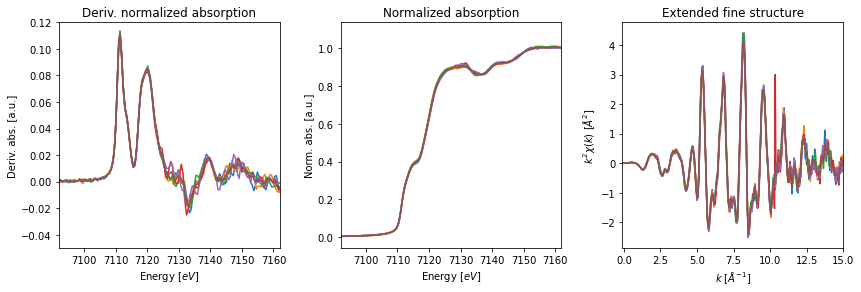

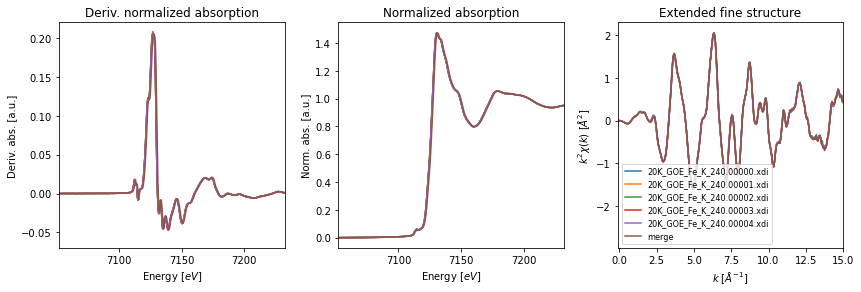

In [6]:
%matplotlib inline

# plot figure of spectra + merge
from araucaria.plot import fig_merge
import matplotlib.pyplot as plt

# dict arguments to figure
fig_kws  = {'figsize'  : (12, 4.0)}

# figure parameters for merged reference
fig_pars = {'e_range'  : (e0-20, e0+50),
           'dmu_range' : [-0.05,0.12],
           'k_range'   : [-0.1,15.0],
           'k_mult'    : 2,
           }

# creating and showing plot for merged reference scans
fig, axes= fig_merge(mgroup_ref, collection, fig_pars=fig_pars, **fig_kws)

# figure parameters for merged scan
fig_pars = {'e_range'  : (e0-60, e0+120),
           'dmu_range' : [-0.07,0.22],
           'k_range'   : [-0.1,15.0],
           'k_mult'    : 2,
           }

# creating and showing plot for merged scans
fig, axes= fig_merge(mgroup, collection, fig_pars=fig_pars, **fig_kws)
axes[2].legend(fontsize=8)
plt.show()